In [24]:
%run Transformer.ipynb

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

# Load the dataset, 15% of the trainning data used for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size=0.15, stratify=y_train_valid)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train-769, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val-769, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test-769, dtype=torch.long)

print(X_train.shape)

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True, drop_last=True)

torch.Size([1797, 22, 1000])


In [20]:
def randomly_crop(X, crop_len):
    # Randomly crop part of the sequence
    seq_len = X.shape[2]
    start_i = torch.randint(0, seq_len-crop_len+1, (1,))
    crop_idx = torch.arange(crop_len) + start_i
    croppedX = X[:, :, crop_idx]
    return croppedX

def model_train(num_epochs, model, optimizer):
    val_acc = []
    val_loss = []
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    
    crit = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
    for i in range(num_epochs):
        batch_loss = []
        batch_acc = []
        model.train()
        for X_train, y_train in dataloader:
            optimizer.zero_grad()
            
            # Crop training sequence and add noide
            crop_len = np.random.randint(590, 611)
            X_train = X_train[:, :, :610]
            X_train = X_train + torch.randn(X_train.shape)/2
            X_train = randomly_crop(X_train, crop_len)
            y_predict = model(X_train)
            loss = crit(y_predict, y_train)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            
            # Log training history for this epoch
            batch_loss.append(loss.item())
            y_predict = torch.argmax(model(X_train), dim=1)
            batch_acc.append((y_predict==y_train).sum().item()/y_train.shape[0])
        
        train_loss.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))
        
        # Evaluation on the eval set and log info
        model.eval()
        scores = model(X_val[:, :, :600])
        y_predict = torch.argmax(scores, dim=1)
        validation_accuracy = ((y_predict==y_val).sum().item()/y_val.shape[0])
        val_acc.append(validation_accuracy)
        loss = crit(scores, y_val)
        val_loss.append(loss.item())
        
        
        # Evaluation on the test set and log info
        scores = model(X_test[:, :, :600])
        y_predict = torch.argmax(scores, dim=1)
        test_accuracy = ((y_predict==y_test).sum().item()/y_test.shape[0])
        test_acc.append(test_accuracy)
        loss = crit(scores, y_test)
        test_loss.append(loss.item())
        
        # Save the model with the best performance
        """
        if validation_accuracy > max(val_acc):
            torch.save(model, "best_val.pth")
        if loss < min(val_loss):
            torch.save(model, "best_loss.pth")
        """
        
        if i%30 == 0:
            print("Iter", i)
            print("Training Loss: ", np.mean(train_loss[-30:]))
            print("Training accuracy: ", np.mean(train_acc[-30:]))
            print("Validation Loss: ", np.mean(val_loss[-30:]))
            print("Validation Accuracy: ", np.mean(val_acc[-30:]))
            print("Test Loss: ", np.mean(test_loss[-30:]))
            print("Test Accuracy: ", np.mean(test_acc[-30:]))
            print()
    
    return train_loss, train_acc, val_loss, val_acc, test_loss, test_acc

In [22]:
%run Transformer.ipynb
t_config = {'d_model':64, 
            'nhead':8,
            'dropout':0.2, 
            'dim_feedforward':64}
transformer = Transformer(t_config)
transformer_optimizer = optim.Adam(transformer.parameters(), lr=1e-3, weight_decay=1e-3)
train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = model_train(1000, transformer, transformer_optimizer)

Iter 0
Training Loss:  1.5127492301604326
Training accuracy:  0.24294117647058822
Validation Loss:  1.4000015258789062
Validation Accuracy:  0.24528301886792453
Test Loss:  1.4020644426345825
Test Accuracy:  0.22121896162528218

Iter 30
Training Loss:  1.378970754847807
Training accuracy:  0.3141176470588235
Validation Loss:  1.3700858354568481
Validation Accuracy:  0.3026205450733752
Test Loss:  1.3645775397618611
Test Accuracy:  0.32791572610985703

Iter 60
Training Loss:  1.2323991948483035
Training accuracy:  0.4727843137254902
Validation Loss:  1.250611460208893
Validation Accuracy:  0.43951781970649895
Test Loss:  1.2596518437067667
Test Accuracy:  0.45598194130925507

Iter 90
Training Loss:  1.065696894538169
Training accuracy:  0.6069607843137257
Validation Loss:  1.1064778248469034
Validation Accuracy:  0.5605870020964361
Test Loss:  1.125327213605245
Test Accuracy:  0.5526711813393529

Iter 120
Training Loss:  0.9357051754699033
Training accuracy:  0.6892352941176471
Validati

0.7697516930022573


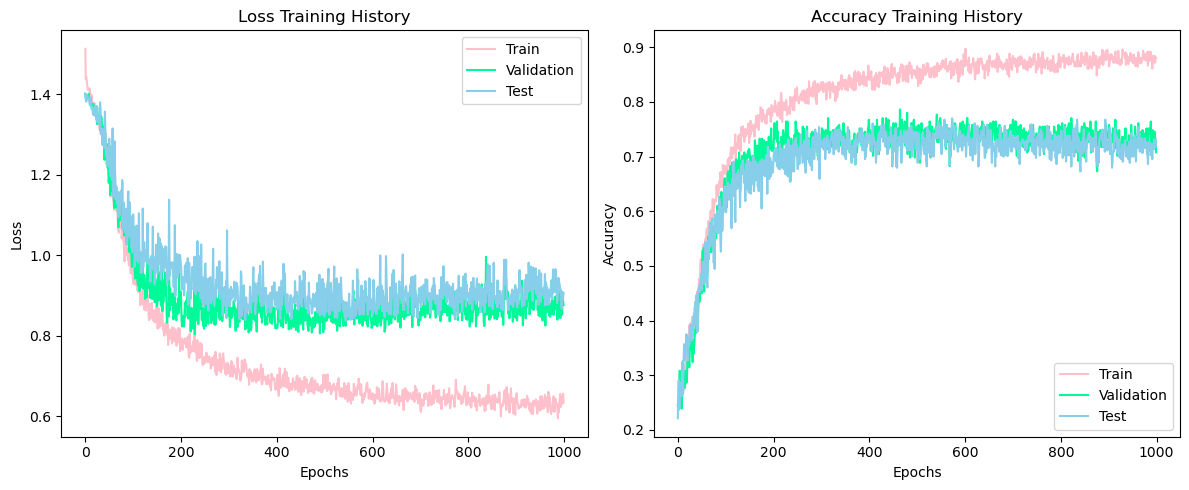

In [30]:
print(max(test_acc))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'pink', label='Train')
plt.plot(val_loss, 'mediumspringgreen', label='Validation')
plt.plot(test_loss, 'skyblue', label='Test')
plt.title('Loss Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, 'pink', label='Train')
plt.plot(val_acc, 'mediumspringgreen', label='Validation')
plt.plot(test_acc, 'skyblue', label='Test')
plt.title('Accuracy Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
